### Spike-field analysis example
In this example we show how to perform spike-field analyses using `pylabianca` and `mne` ([MNE-Python](https://mne.tools/stable/index.html)).

In [1]:
import os
import os.path as op

import numpy as np
import pandas as pd

import mne
import pylabianca as pln

%load_ext autoreload
%autoreload 2

### Reading LFP data 
We will first read example FieldTrip plexon nex (NeuroExplorer) data. `pylabianca.io.read_analog_plexon_nex()` reads continuous signal traces as mne Raw objects:

In [2]:
ft_data_dir = r'C:\Users\Asus\Dropbox\Sarenka\PROJECTS\pylabianca\ft_data'
fname = 'p029_sort_final_01.nex'

raw = pln.io.read_analog_plexon_nex(op.join(ft_data_dir, fname))

Creating RawArray with float64 data, n_channels=6, n_times=7555983
    Range : 179 ... 7556161 =      0.179 ...  7556.161 secs
Ready.


We can inspect these data below. We set the browser backend to matplotlib temporarily, so that the figure is saved in the notebook and not opened intervactively.

Using matplotlib as 2D backend.


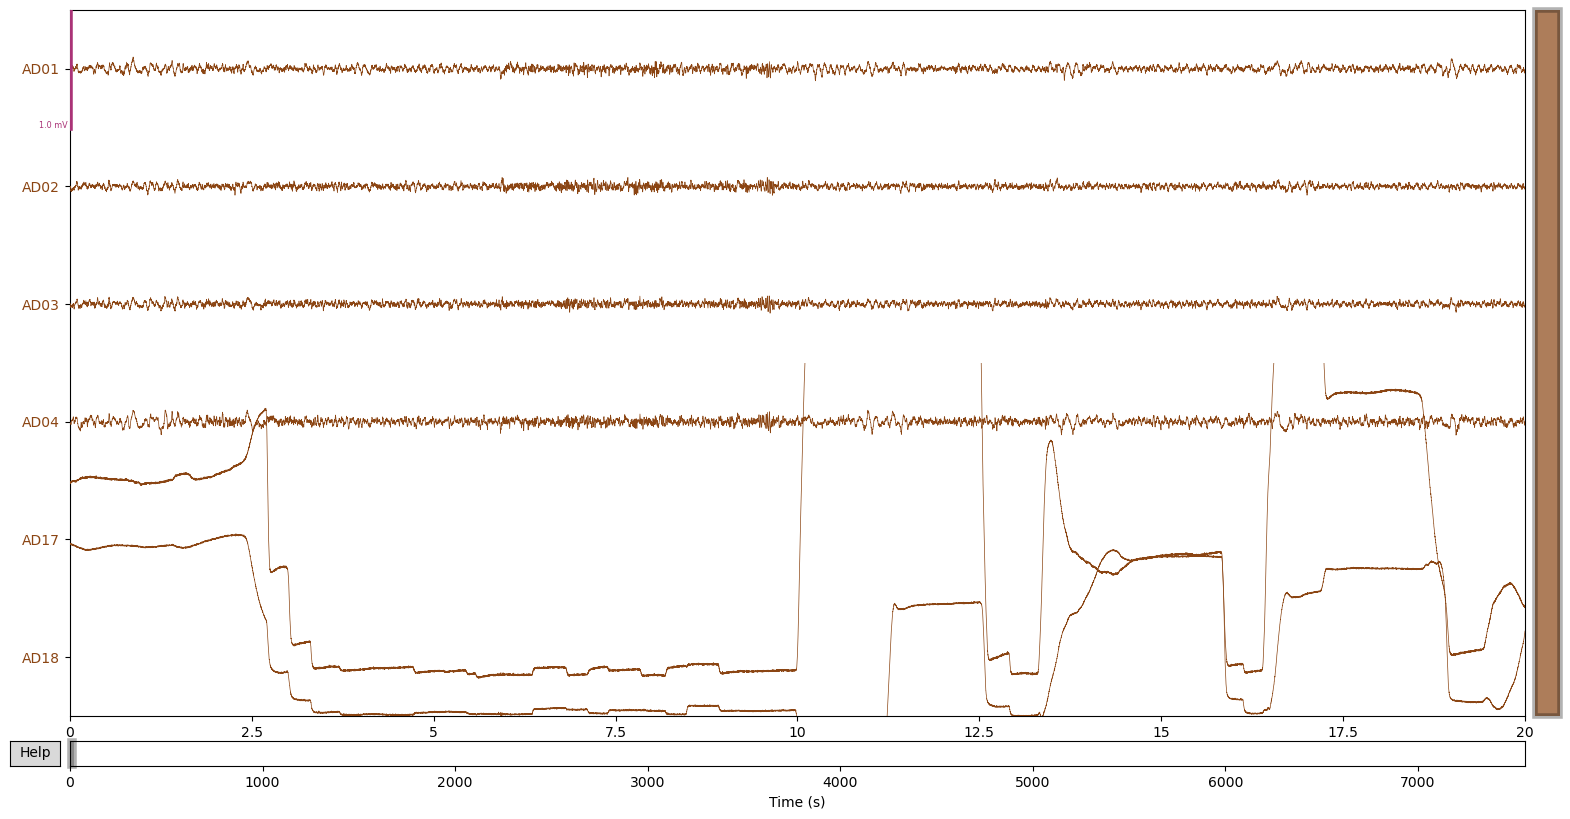

In [3]:
with mne.viz.use_browser_backend('matplotlib'):
    raw.plot(duration=20., scalings=5e-4);

for some reason mne's `set_browser_backend()` and `use_browser_backend()` mess up matplotlib's inline mode, so we call that mode again:

In [24]:
%matplotlib inline

We see that the first four channels contain LFP signals, but the last two - likely EOG. We could specify this in the `raw` object using `.set_channel_types()` method, but we will leave it this way for now.  

### Read and epoch spikes
Now we will read spikes and events and:
* epoch spike data with respect to stimulus presentation
* change events from timestamps to LFP samples
* epoch raw signal with respect to the same events

In [4]:
spk = pln.io.read_plexon_nex(op.join(ft_data_dir, fname))
events = pln.io.read_events_plexon_nex(op.join(ft_data_dir, fname), format='mne')

we first select only cells with waveforms:

In [5]:
has_waveforms = [wave is not None for wave in spk.waveform]
spk.pick_cells(has_waveforms)

<Spikes, 7 cells, 302635.0 spikes/cell on average>

and epoch with respect to stimulation onset (event `10030`):

In [7]:
spk_epochs = spk.epoch(events, event_id=10030, tmin=-2.75, tmax=2.75)

### Resampling events to epoch LFP
To epoch raw lfp, we will have to take into account the differences in sampling rate. The events are in timestamps corresponding to `spk.sfreq` property (this can be sampling frequency of the signal that the spikes were extracted from or timestamp frequency - as in Neuralynx files sorted with Osort). The pylabianca `Spikes` object contains spike times in timestamps, so using the `events` without modification is ok. However, to epoch raw lfp signal we need to convert the event timestamps to lfp sample indices. We'll first compare sampling frequency of `spk` and `raw` to know how much to downsample.

In [8]:
spk.sfreq

40000.0

In [9]:
raw.info['sfreq']

1000.0

In [10]:
downsample = spk.sfreq / raw.info['sfreq']

In [11]:
events_smp = events.copy()
samples = np.round(events[:, 0] / downsample).astype(int)
events_smp[:, 0] = samples - 1  # -1 is done to get python 0-based indexing

In [12]:
lfp_epochs = mne.Epochs(raw, events_smp, event_id=10030,
                        tmin=-2.75, tmax=2.75, preload=True)

Not setting metadata
897 matching events found
Setting baseline interval to [-2.75, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 897 events and 5501 original time points ...
0 bad epochs dropped


we will make sure that we have the same number of trials in spikes and LFP:

In [13]:
len(lfp_epochs) == len(spk_epochs)

True

### Adding metadata
We will add metadata table to know which trials correspond to specific conditions or correct responses.

In [14]:
metadata = pd.read_csv(op.join(ft_data_dir, 'monkey_stim.csv'))
metadata.head()

,has_stimon,has_targetchange,has_distractorchange,condition,correct,change_first,attention
0,True,True,False,20001,False,target,in
1,False,False,False,20002,False,distractor,in
2,False,False,False,20001,False,target,in
3,False,False,False,20001,False,target,in
4,False,False,False,20001,False,target,in


This metadata file contains information about all trials, even those where the simulus was not presented (most likely the monkey released the lever to early), but our epochs are with respect to stimulus onset, so we will select only trials with stimulus presentation:

In [15]:
print('metadata shape:', metadata.shape)
print('number of epochs:', len(spk_epochs))

metadata shape: (1028, 7)
number of epochs: 897


In [16]:
metadata = metadata.query('has_stimon == True')

now we can add metadata to spikes and lfp:

In [17]:
spk_epochs.metadata = metadata
lfp_epochs.metadata = metadata

Adding metadata with 7 columns


we select only correct trials

In [18]:
spk_epochs = spk_epochs['correct == True']
lfp_epochs = lfp_epochs['correct == True']

In [19]:
len(spk_epochs) == len(lfp_epochs)

True

### Ploting LFP ERP and spike rate

We will now plot average figing rate for one cell and average LFP event related potential from one channel:

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


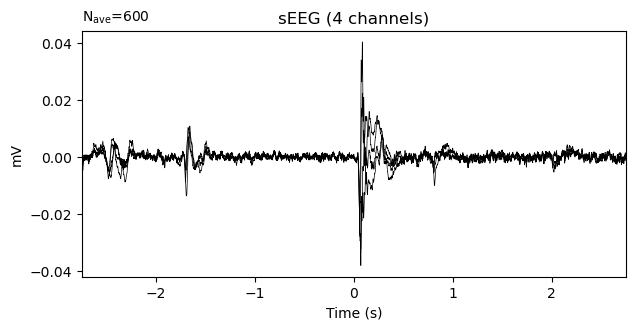

In [20]:
erp = lfp_epochs.average()
erp.plot(picks=['AD01', 'AD02', 'AD03', 'AD04']);

also, spike rate in the same time window:

<Axes: title={'center': 'cell = sig002U_wf, name = sig002U_wf, id = 14, ...'}, xlabel='Time (s)', ylabel='Firing density (Hz)'>

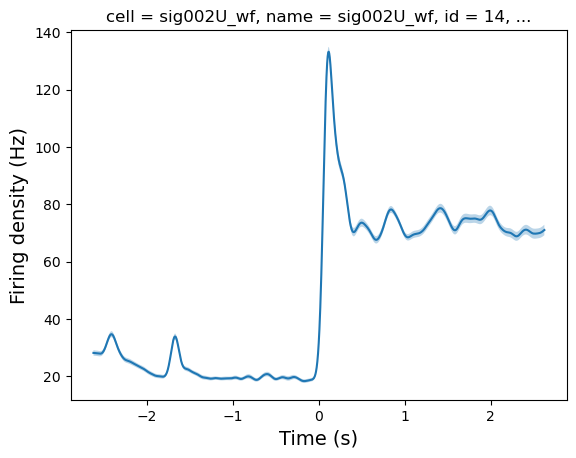

In [25]:
fr = spk_epochs.spike_density(picks=2, fwhm=0.1)
pln.viz.plot_shaded(fr)

### Create spike-centered windows
We will take a look at spike-triggered LFP averages in the poststimulus period (from 0.3 seconds post-stimulus).
First we will crop the data to the poststimulus time:

In [26]:
channels = ['AD01', 'AD02', 'AD03', 'AD04']
lfp_poststim = (
    lfp_epochs.copy()
    .crop(tmin=0.3)
    .pick(channels)
)
spk_poststim = spk_epochs.copy().crop(tmin=0.3)

now we create spike-centered windows

In [27]:
lfp_trig = pln.utils.spike_centered_windows(
    spk_poststim, lfp_poststim,
    pick='sig002a_wf', winlen=0.4)

The returned array is of the shape `spikes x channels x timesamples`. The first dimension corresponds to the spikes of the chosen unit from `spk_epochs_correct_prestim` and the last dimension corresponds to timesamples of the timewindow - we chose a `winlen` of `0.4` so `-0.2` and `+0.2` with respect to each spike.

In [28]:
lfp_trig.dims

('spike', 'channel', 'time')

we will remove average of each window

In [29]:
lfp_trig -= lfp_trig.mean(dim='time')

### spike-triggered LFP average
the average of these windows is the spike-triggered LFP average:

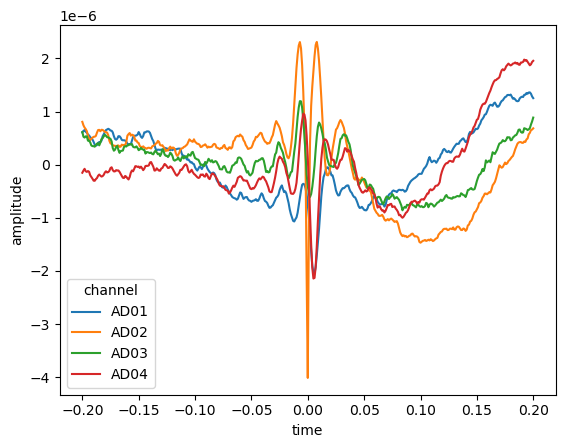

In [31]:
lfp_trig_avg = lfp_trig.mean(axis=0)
lfp_trig_avg.plot(hue='channel')

We can see a nice high-frequency oscillation in the middle suggesting that spike time depends on the phase of that oscillation.  
To plot the average with confidence intervals we can use `pln.viz.plot_shaded` (but then we have to select one channel):

<Axes: title={'center': 'channel = AD03'}, xlabel='Time', ylabel='Amplitude (V)'>

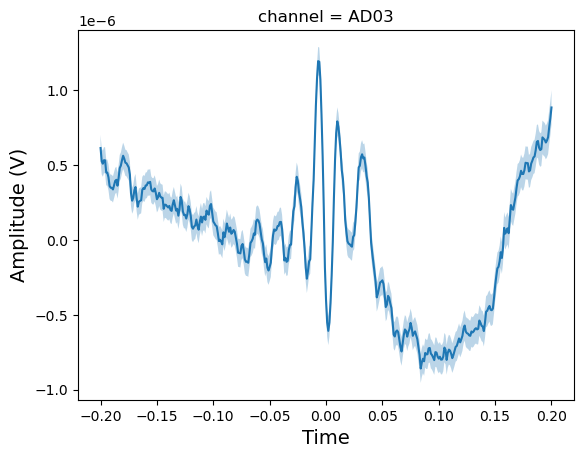

In [33]:
pln.viz.plot_shaded(lfp_trig.sel(channel='AD03'))

### Interpolating spike artifact

We can see that LFP of channel AD02 displays spike artifact at time 0. The spikes of the unit we used for extracting spike-centered windows were likely detected on this channel (before downsampling), so the LFP still contains some leakage from high-frequency spike events.

<Axes: title={'center': 'channel = AD02'}, xlabel='Time', ylabel='Amplitude (V)'>

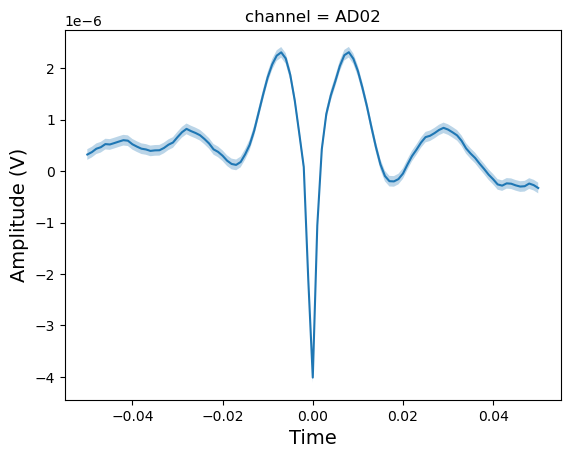

In [35]:
pln.viz.plot_shaded(lfp_trig.sel(channel='AD02', time=slice(-0.05, 0.05)))

To remove the spike artifact we could interpolate the middle samples for this channel before averaging (this may take a couple of seconds as thousands of lines have to be interpolated).

In [36]:
# create a copy to not modify the original signal
lfp_trig_interp = lfp_trig.copy()

# set time close to 0. of channel A02 to np.nan
sel = dict(time=slice(-0.001, 0.001), channel='AD02')
lfp_trig_interp.loc[sel] = np.nan

# interpolate all nan's (in this case - using cubic interpolation) 
lfp_trig_interp = lfp_trig_interp.interpolate_na(
    dim='time', method='cubic')

Compare spike-triggered average before and after interpolation:

<Axes: title={'center': 'channel = AD02'}, xlabel='Time', ylabel='Amplitude (V)'>

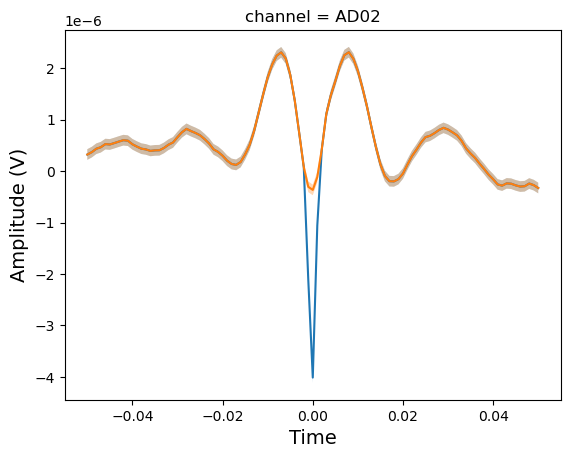

In [37]:
ax = pln.viz.plot_shaded(
    lfp_trig.sel(channel='AD02', time=slice(-0.05, 0.05)),
)
pln.viz.plot_shaded(
    lfp_trig_interp.sel(channel='AD02', time=slice(-0.05, 0.05)),
    ax=ax)

### Comparing conditions
because the spike-triggered LFP xarray inherited all trial-level metadata, we could compare conditions: 

<Axes: title={'center': 'channel = AD03'}, xlabel='Time', ylabel='Amplitude (V)'>

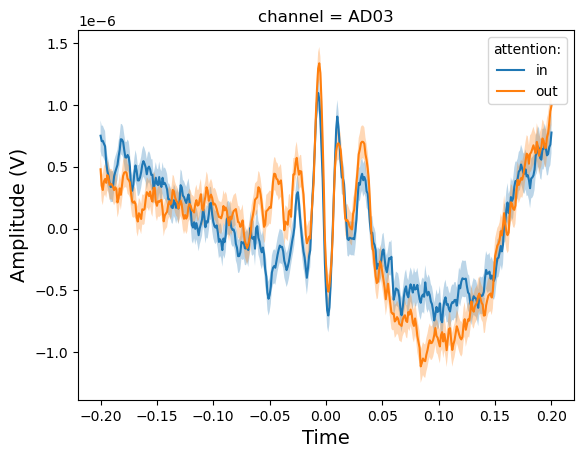

In [38]:
pln.viz.plot_shaded(lfp_trig.sel(channel='AD03'), groupby='attention')

### Compute spike-triggered spectrum
We will use multitaper method to compute spectrum of the spike-centered windows average.

In [39]:
psd, freq = mne.time_frequency.psd_array_multitaper(
    lfp_trig.sel(channel='AD03').mean(dim='spike'),
    sfreq=raw.info['sfreq'], bandwidth=7, fmin=10, fmax=100
)

    Using multitaper spectrum estimation with 2 DPSS windows


In [41]:
import matplotlib.pyplot as plt

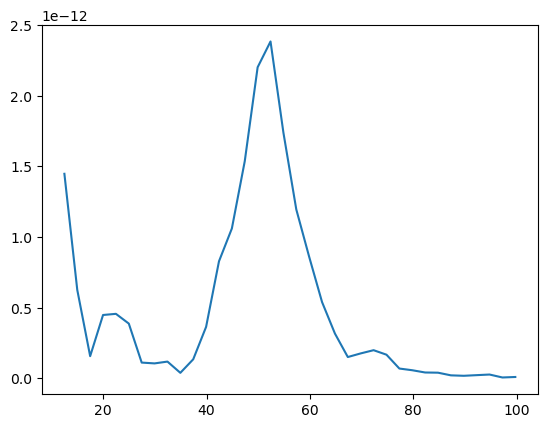

In [42]:
plt.plot(freq, psd)
plt.show()

We see spectral peak around 50 Hz.

### Compare to shuffled data
We will compare the obtained spike-triggered LFP spectrum to one obtained from data where the spike-LFP relationship is abolished by shuffling trials in the spike data (we can either shuffle the LFP or spikes).

In [45]:
new_spk = pln.utils.shuffle_trials(spk_poststim)

In [46]:
lfp_trig_shuff = pln.utils.spike_centered_windows(
    new_spk, lfp_poststim,
    pick='sig002a_wf', winlen=0.4)
lfp_trig_shuff -= lfp_trig_shuff.mean(dim='time')

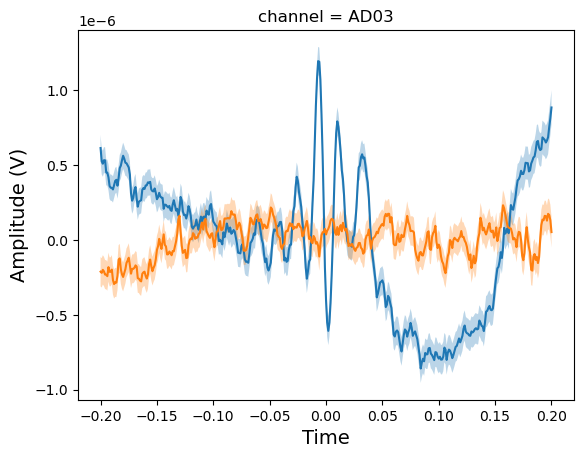

In [48]:
ax = pln.viz.plot_shaded(lfp_trig.sel(channel='AD03'))
pln.viz.plot_shaded(lfp_trig_shuff.sel(channel='AD03'), ax=ax)
plt.show()

We cen see that the high-frequency oscillations around time 0 is now absent. Let's show this on the spectrum:

In [49]:
psd_shuff, freq = mne.time_frequency.psd_array_multitaper(
    lfp_trig_shuff.sel(channel='AD03').mean(dim='spike'),
    raw.info['sfreq'], bandwidth=7, fmin=10, fmax=100
)

    Using multitaper spectrum estimation with 2 DPSS windows


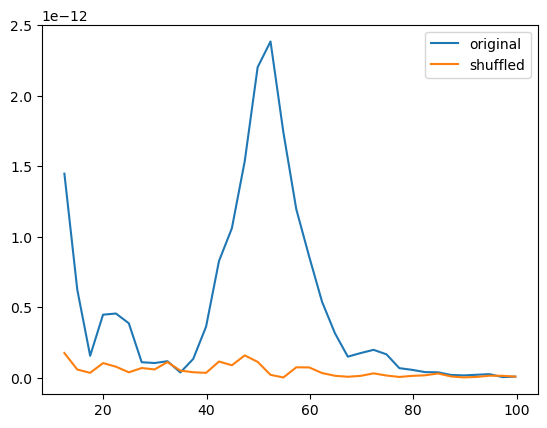

In [50]:
plt.plot(freq, psd, label='original')
plt.plot(freq, psd_shuff, label='shuffled')
plt.legend()
plt.show()

(we can also see that some lower frequencies are reduced now)